# **Imports**

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_openml
from scipy.ndimage import uniform_filter
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
import os
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from keras.datasets import mnist

# **Load MINST dataset**

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


# **Train Test Split**

In [3]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [4]:
def divide2blocks(X, num_blocks):
  # X_reshaped = X.reshape(-1, 28, 28)
  block_size = 28 // int(np.sqrt(num_blocks))
  images = []
  for img in X:
    X_blocks = []
    for j in range(int(np.sqrt(num_blocks))):
        for i in range(int(np.sqrt(num_blocks))):
            block = img[j*block_size:(j+1)*block_size, i*block_size:(i+1)*block_size]
            X_blocks.append(block)
    images.append(X_blocks)
  images=np.array(images)

  return images


In [5]:
import numpy as np

def calculate_x_bar(img):
    XY = []
    for i in range(len(img)):
        feature_vector = []
        for block in range(len(img[i])):
            x_bar = 0
            y_bar = 0
            denominator = np.sum(img[i][block])

            numerator1 = 0
            for x in range(len(img[i][block])):
                for y in range(len(img[i][block][x])):
                    numerator1 += x * img[i][block][x][y]

            numerator2 = 0
            for y in range(img.shape[3]):
                for x in range(img.shape[2]):
                    numerator2 += y * img[i][block][x][y]

            if denominator != 0:
                x_bar = numerator1 / denominator
                y_bar = numerator2 / denominator

            feature_vector.append(x_bar)
            feature_vector.append(y_bar)

        feature_vector = np.array(feature_vector)
        XY.append(feature_vector)

    XY = np.array(XY)
    return XY


# **Chain Code**

In [6]:
from skimage.measure import find_contours

def chain_code(image):
    contours = find_contours(image, 0.5)
    if len(contours) == 0:
        return np.zeros(8)
    contour = contours[0]
    dx = np.diff(contour[:, 1])
    dy = np.diff(contour[:, 0])
    directions = np.array([np.arctan2(dy_, dx_) for dx_, dy_ in zip(dx, dy)])
    bin_edges = np.linspace(-np.pi, np.pi, 9)
    chain = np.histogram(directions, bins=bin_edges)[0]
    return chain



In [7]:
def extract_features(images, block_size=(2, 2)):
    h_blocks, w_blocks = block_size
    block_h_size = images.shape[1] // h_blocks
    block_w_size = images.shape[2] // w_blocks
    features = []
    for image in images:
        feature_vector = []
        for i in range(h_blocks):
            for j in range(w_blocks):
                block = image[i*block_h_size:(i+1)*block_h_size, j*block_w_size:(j+1)*block_w_size]
                feature_vector.extend(chain_code(block))
        features.append(feature_vector)
    return np.array(features)

# **K-means**

In [8]:
def kmeans(X, k, max_iters=100):
    np.random.seed(42)
    centroids = X[np.random.choice(X.shape[0], k, replace=False)]

    for _ in range(max_iters):
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)
        new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])

        if np.allclose(centroids, new_centroids):
            break

        centroids = new_centroids

    return labels, centroids

# **Feature extraction**

In [9]:
centroid_features_train = calculate_x_bar(divide2blocks(X_train, num_blocks=4))

In [10]:
centroid_features_test = calculate_x_bar(divide2blocks(X_test, num_blocks=4))

In [11]:
chain_code_features_train = extract_features(X_train)

In [12]:
chain_code_features_train = extract_features(X_test)

# **K-means clustering on centroid features**

In [13]:
centroid_labels, centroid_centroids = kmeans(centroid_features_train, k=10)

# **K-means clustering on chain code features**

In [14]:
chain_code_labels, chain_code_centroids = kmeans(chain_code_features_train, k=10)

# **Compare the performance of K-means with centroid features and chain code features**

In [15]:
actual_distribution = np.bincount(y_train)
centroid_distribution_custom = np.bincount(centroid_labels)
chain_code_distribution_custom = np.bincount(chain_code_labels)

In [27]:
# Print the distributions as a table
print("Class\tActual\tCentroid Features\tChain Code Features")
for i in range(len(actual_distribution)):
    print(f"{i}\t{actual_distribution[i]}\t{centroid_distribution_custom[i]}\t{chain_code_distribution_custom[i]}")

Class	Actual	Centroid Features	Chain Code Features
0	4118	3833	805
1	4748	298	1147
2	4199	3574	834
3	4285	5808	767
4	4116	372	981
5	3768	7921	1416
6	4131	3946	912
7	4328	6216	683
8	4121	7007	1255
9	4186	3025	1200


In [26]:
# Compare based on which feature set has a lower sum of within-cluster distances
centroid_within_cluster_distances_custom = np.sum(np.min(np.linalg.norm(centroid_features_train[:, np.newaxis] - centroid_centroids, axis=2), axis=1))
chain_code_within_cluster_distances_custom = np.sum(np.min(np.linalg.norm(chain_code_features_train[:, np.newaxis] - chain_code_centroids, axis=2), axis=1))

print("\nSum of within-cluster distances using centroid features (custom function):")
print(centroid_within_cluster_distances_custom)
print("\nSum of within-cluster distances using chain code features (custom function):")
print(chain_code_within_cluster_distances_custom)



Sum of within-cluster distances using centroid features (custom function):
107611.09137777325

Sum of within-cluster distances using chain code features (custom function):
92335.8166627068


In [18]:

# Compare based on which feature set has a lower sum of within-cluster distances
if centroid_within_cluster_distances_custom < chain_code_within_cluster_distances_custom:
    print("\nCentroid features perform better (custom function).")
else:
    print("\nChain code features perform better (custom function).")


Chain code features perform better (custom function).


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_clusters(X, labels, centroids, title):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    centroids_pca = pca.transform(centroids)

    plt.figure(figsize=(10, 6))
    for i in range(len(np.unique(labels))):
        plt.scatter(X_pca[labels == i][:, 0], X_pca[labels == i][:, 1], label=f'Cluster {i}', alpha=0.5)
    plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], marker='X', color='black', label='Centroids')
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()


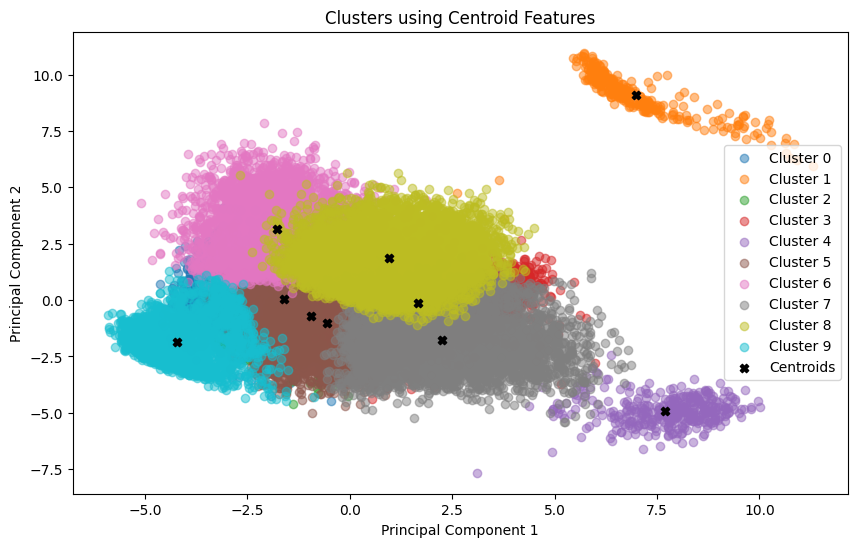

In [20]:
# Plot clusters using centroid features
plot_clusters(centroid_features_train, centroid_labels, centroid_centroids, 'Clusters using Centroid Features')

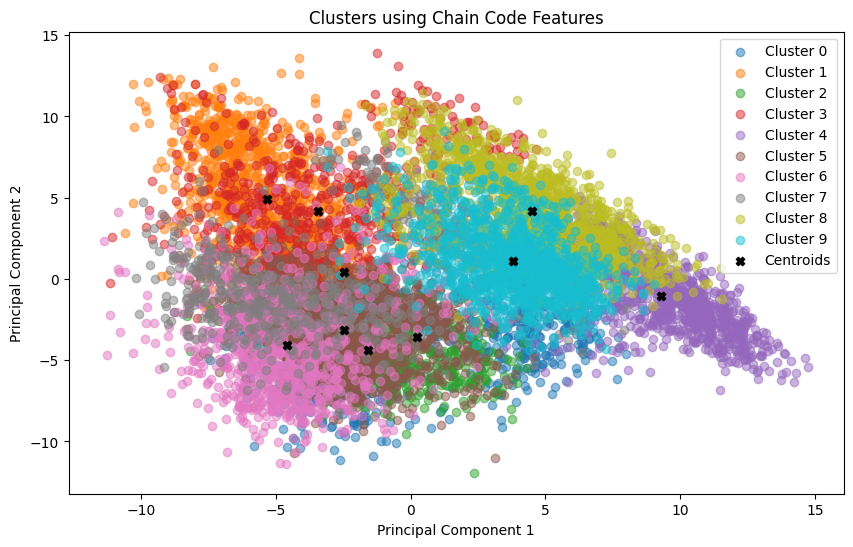

In [21]:
# Plot clusters using chain code features
plot_clusters(chain_code_features_train, chain_code_labels, chain_code_centroids, 'Clusters using Chain Code Features')

In [38]:
def plot_cluster_distribution(distribution, title):
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(distribution)), distribution, color='pink')
    plt.title(title)
    plt.xlabel('Cluster')
    plt.ylabel('Number of Samples')
    plt.show()


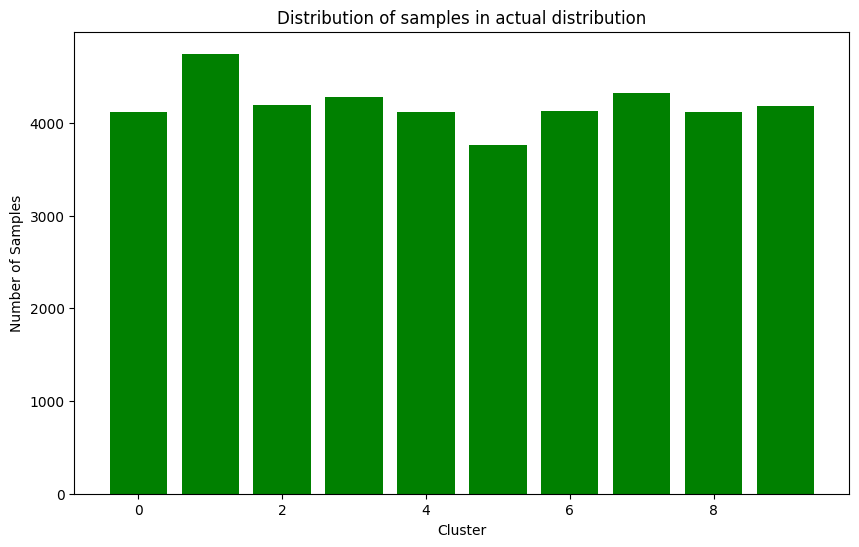

In [29]:
plot_cluster_distribution(actual_distribution, 'Distribution of samples in actual distribution')

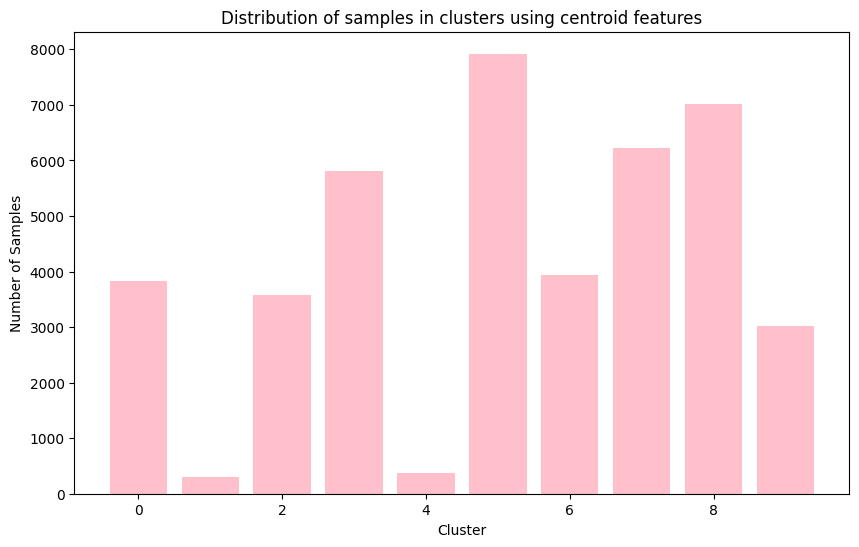

In [39]:
plot_cluster_distribution(centroid_distribution_custom, 'Distribution of samples in clusters using centroid features')

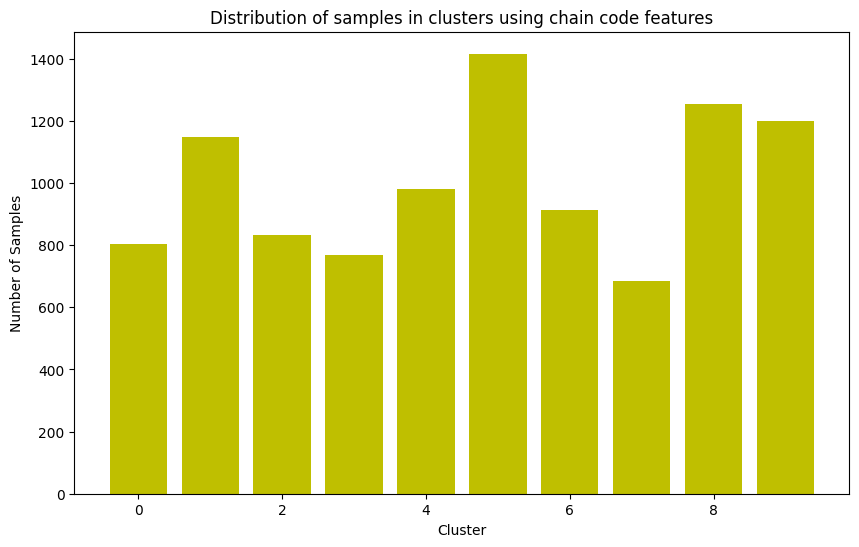

In [33]:
plot_cluster_distribution(chain_code_distribution_custom, 'Distribution of samples in clusters using chain code features')